In [2]:
%matplotlib inline

Dtaset
DataLoader


# Datasets & DataLoaders


PyTorch provides two data primitives: ``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``
that allow you to use pre-loaded datasets as well as your own data.
* ``Dataset`` stores the samples and their corresponding labels,
* ``DataLoader`` wraps an iterable around the ``Dataset`` to enable easy access to the samples.
* PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass ``torch.utils.data.Dataset`` and implement functions specific to the particular data.





## Example:  Fashion-MNIST Dataset

* Fashion-MNIST is a dataset of images consisting of 60,000 training examples and 10,000 test examples.
* Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.

We load the [FashionMNIST Dataset](https://pytorch.org/vision/stable/datasets.html#fashion-mnist) with the following parameters:
 - ``root`` is the path where the train/test data is stored,
 - ``train`` specifies training or test dataset,
 - ``download=True`` downloads the data from the internet if it's not available at ``root``.
 - ``transform`` and ``target_transform`` specify the feature and label transformations



In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## Iterating and Visualizing the Dataset

We can index ``Datasets`` manually like a list: ``training_data[index]``.
We use ``matplotlib`` to visualize some samples in our training data.



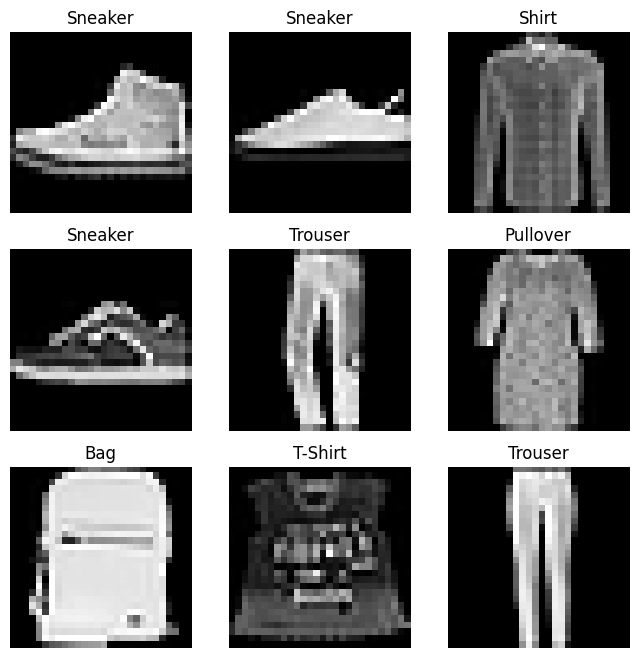

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

--------------




## Creating a Custom Dataset

* A custom Dataset class must inherit the ``Dataset`` class and implement three functions: `__init__`, `__len__`, and `__getitem__`.




### Example: The Iris Dataset

**Iris**: The data report four characteristics (sepal width, sepal length, petal width and petal length) of three species of Iris flower. 

Species_No: Flower species as a code (1: setosa, 2: versicolor, 3: verginica)
Species_Name: Species name 
Petal_Width: Petal Width 
Petal_Length: Petal Length 
Sepal_Width: Sepal Width 
Sepal_Length: Sepal Length

![Iris Dataset](data/Iris/iris_image.png) 


In [5]:
import pandas as p

df = pd.read_csv("data/Iris/Iris1.csv")
print(df.head())


NameError: name 'pd' is not defined

In [11]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd

class IrisDataset(Dataset):
    def __init__(self, file, transform=None, target_transform=None):
        self.data = pd.read_csv(file)
        self.y = self.data['Species_No']-1
        self.X = self.data[['Petal_width','Petal_length','Sepal_width','Sepal_length']]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        y = self.y[idx]
        x = self.X.iloc[idx,:].to_numpy()
        if self.transform:
            image = self.transform(x)
        if self.target_transform:
            label = self.target_transform(y)
        return x, y
    



### Example: The FashionMNIST Dataset
the FashionMNIST images are stored in a directory ``img_dir``, and their labels are stored separately in a CSV file ``annotations_file``.

In [12]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

--------------




# Spliting your data into train and test sets

In [13]:
from torch.utils.data import random_split
iris_dataset = IrisDataset("data/Iris/Iris1.csv")
iris_dataset_train, iris_dataset_test = random_split(iris_dataset, [100, 50], generator=torch.Generator().manual_seed(42))


## Preparing your data for training with DataLoaders
The ``Dataset`` retrieves our dataset's features and labels one sample at a time. While training a model, we typically want to pass samples in "minibatches" and reshuffle the data at every epoch to reduce model overfitting

``DataLoader`` is an iterable that abstracts this complexity for us in an easy API.



In [14]:
from torch.utils.data import DataLoader
iris_dataset_train_dataLoader = DataLoader(iris_dataset_train, batch_size=5, shuffle=True)
iris_dataset_test_dataLoader = DataLoader(iris_dataset_test, batch_size=5, shuffle=True)



## Iterate through the DataLoader

* We have loaded that dataset into the ``DataLoader`` and can iterate through the dataset as needed.
* Each iteration below returns a batch of ``X`` and ``y`` (containing ``batch_size=12`` features and labels respectively).
* Because we specified ``shuffle=True``, after we iterate over all batches the data is shuffled 



In [18]:
batch_X, batch_y = next(iter(iris_dataset_test_dataLoader))
print(batch_X)
print(batch_y)

tensor([[1.8000, 6.0000, 3.2000, 7.2000],
        [1.0000, 3.7000, 2.4000, 5.5000],
        [1.8000, 5.5000, 3.1000, 6.4000],
        [1.0000, 3.5000, 2.6000, 5.7000],
        [2.5000, 5.7000, 3.3000, 6.7000]], dtype=torch.float64)
tensor([2, 1, 2, 1, 2])


--------------




# Build the Neural Network

* Neural networks comprise of layers/modules that perform operations on data.
* The ``torch.nn`` namespace provides all the building blocks you need to build your own neural network.
* Every module in PyTorch subclasses the ``nn.Module``.


In [19]:
from torch import nn

## Get Device for Training
We want to be able to train our model on a hardware accelerator like the GPU,
if it is available. Let's check to see if ``torch.cuda`` is available, else we
continue to use the CPU.

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
device = "cpu"

Using cuda device


## Define the Class
* We define our neural network by subclassing ``nn.Module``
* We initialize the neural network layers in ``__init__``.
* Every ``nn.Module`` subclass implements the operations on input data in the ``forward`` method.

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_layers = nn.Sequential(
            nn.Linear(4, 50, bias = False),
            nn.ReLU(),
            nn.Linear(50, 20, bias = False),
            nn.ReLU(),
            nn.Linear(20, 3, bias = False),
        )
        

    def forward(self, x):
        return  self.linear_relu_layers(x)

In [32]:
model = NeuralNetwork().to(device)
print(model)
iris_dataset_test_dataLoader.to(device)

NeuralNetwork(
  (linear_relu_layers): Sequential(
    (0): Linear(in_features=4, out_features=50, bias=False)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=False)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=3, bias=False)
  )
)


AttributeError: 'DataLoader' object has no attribute 'to'

**Lets test the model**

$softmax(x) = \frac{e^{x_i}}{\sum_{j=1}^{K}e^{x_j}}$

In [33]:

results = model(batch_X.float().to(device))
print(f'Network Output: {results}')

#convert the results to probabilities
pred_probab = nn.Softmax(dim=1)(results)
print(f'Probabilities: {pred_probab}')

y_pred = pred_probab.argmax(1)+1
print(f"Predicted class: {y_pred}")

print(f'True class: {batch_y}')

Network Output: tensor([[ 0.0828, -0.4290,  0.7035],
        [ 0.0388, -0.2655,  0.5551],
        [ 0.0841, -0.3984,  0.6242],
        [ 0.0367, -0.2511,  0.5775],
        [ 0.1006, -0.4162,  0.6329]], grad_fn=<MmBackward>)
Probabilities: tensor([[0.2891, 0.1733, 0.5377],
        [0.2929, 0.2161, 0.4910],
        [0.3000, 0.1852, 0.5149],
        [0.2884, 0.2163, 0.4953],
        [0.3031, 0.1808, 0.5161]], grad_fn=<SoftmaxBackward>)
Predicted class: tensor([3, 3, 3, 3, 3])
True class: tensor([2, 1, 2, 1, 2])


## Model Parameters
In this example, we iterate over each parameter, and print its size and a preview of its values.


In [34]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (linear_relu_layers): Sequential(
    (0): Linear(in_features=4, out_features=50, bias=False)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=False)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=3, bias=False)
  )
)


Layer: linear_relu_layers.0.weight | Size: torch.Size([50, 4]) | Values : tensor([[ 0.1580,  0.4828, -0.1613,  0.0705],
        [ 0.2493,  0.0956,  0.4601, -0.4530]], grad_fn=<SliceBackward>) 

Layer: linear_relu_layers.2.weight | Size: torch.Size([20, 50]) | Values : tensor([[ 0.0067, -0.0611,  0.1044, -0.1220, -0.1394,  0.0104, -0.1289, -0.0418,
         -0.0400,  0.1093,  0.0881, -0.1370,  0.1011, -0.0787, -0.0877,  0.0903,
         -0.0976,  0.0660, -0.0374,  0.1394,  0.1110,  0.0069,  0.0368,  0.0893,
          0.0881,  0.1096, -0.1156, -0.1022, -0.1310,  0.0497, -0.0903, -0.0558,
         -0.0796,  0.0840,  0.0678,  0.0910, -0.0441, -0.1111,  0.0020, -0.0564,
         -0.0821, -0.0356,  0.0922,  

# Training the model (parameter optimization) 
1. define a loss function 
2. define an optimizer
3. train the model 
4. test the performance

### Defining a loss function 
* **Loss function** measures the degree of dissimilarity of obtained result to the target value
* We want to minimize the loss function during training. 
* To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.
* Common loss functions for classification include ``nn.MSELoss`` (Mean Square Error), and ``nn.CrossEntropyLoss`` (Cross Entropy Loss)

* **MSELoss:**
$L(o,y) = \frac{1}{N}(l_1+ l_2+ \dots+ l_N), l_i = (o_i-y_i)^2$

* **CrossEntropyLoss:**
$L(o,y) = \sum_{i=1}^{N}(l_1, l_2, \dots, l_N), l_i = -y_i\log(o_i)$ and $o_i$ the softmax value (the probability value)

In [35]:
loss_fn = nn.CrossEntropyLoss()

### Defining an optimizer

* Optimization is the process of adjusting model parameters to reduce model error in each training step.
* Here, we use the SGD optimizer
* There are many different optimizers available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

In [36]:
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Defining a train loop

In [37]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X.float())
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


### Defining a test loop

In [38]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [39]:
epochs = 500
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(iris_dataset_train_dataLoader, model, loss_fn, optimizer)
    test_loop(iris_dataset_test_dataLoader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.350748  [    0/  100]
loss: 1.224465  [   50/  100]
Test Error: 
 Accuracy: 42.0%, Avg loss: 1.080114 

Epoch 2
-------------------------------
loss: 1.048687  [    0/  100]
loss: 1.265125  [   50/  100]
Test Error: 
 Accuracy: 42.0%, Avg loss: 1.065733 

Epoch 3
-------------------------------
loss: 1.145473  [    0/  100]
loss: 1.169921  [   50/  100]
Test Error: 
 Accuracy: 42.0%, Avg loss: 1.056608 

Epoch 4
-------------------------------
loss: 0.980467  [    0/  100]
loss: 1.038061  [   50/  100]
Test Error: 
 Accuracy: 42.0%, Avg loss: 1.049337 

Epoch 5
-------------------------------
loss: 1.173302  [    0/  100]
loss: 1.106023  [   50/  100]
Test Error: 
 Accuracy: 42.0%, Avg loss: 1.042644 

Epoch 6
-------------------------------
loss: 1.108742  [    0/  100]
loss: 1.052057  [   50/  100]
Test Error: 
 Accuracy: 42.0%, Avg loss: 1.036560 

Epoch 7
-------------------------------
loss: 1.096596  [    0/  100]
loss: 1.045635  [ 

loss: 0.780287  [   50/  100]
Test Error: 
 Accuracy: 72.0%, Avg loss: 0.747569 

Epoch 56
-------------------------------
loss: 0.743962  [    0/  100]
loss: 0.673987  [   50/  100]
Test Error: 
 Accuracy: 74.0%, Avg loss: 0.741442 

Epoch 57
-------------------------------
loss: 0.714585  [    0/  100]
loss: 0.633278  [   50/  100]
Test Error: 
 Accuracy: 74.0%, Avg loss: 0.734288 

Epoch 58
-------------------------------
loss: 0.674667  [    0/  100]
loss: 0.649854  [   50/  100]
Test Error: 
 Accuracy: 72.0%, Avg loss: 0.727677 

Epoch 59
-------------------------------
loss: 0.676816  [    0/  100]
loss: 0.664502  [   50/  100]
Test Error: 
 Accuracy: 72.0%, Avg loss: 0.720965 

Epoch 60
-------------------------------
loss: 0.806742  [    0/  100]
loss: 0.681738  [   50/  100]
Test Error: 
 Accuracy: 72.0%, Avg loss: 0.715145 

Epoch 61
-------------------------------
loss: 0.746562  [    0/  100]
loss: 0.627323  [   50/  100]
Test Error: 
 Accuracy: 72.0%, Avg loss: 0.708051 



loss: 0.506556  [   50/  100]
Test Error: 
 Accuracy: 88.0%, Avg loss: 0.512244 

Epoch 110
-------------------------------
loss: 0.457569  [    0/  100]
loss: 0.248022  [   50/  100]
Test Error: 
 Accuracy: 88.0%, Avg loss: 0.510711 

Epoch 111
-------------------------------
loss: 0.419986  [    0/  100]
loss: 0.476465  [   50/  100]
Test Error: 
 Accuracy: 88.0%, Avg loss: 0.507618 

Epoch 112
-------------------------------
loss: 0.442560  [    0/  100]
loss: 0.436329  [   50/  100]
Test Error: 
 Accuracy: 88.0%, Avg loss: 0.504943 

Epoch 113
-------------------------------
loss: 0.457716  [    0/  100]
loss: 0.429396  [   50/  100]
Test Error: 
 Accuracy: 88.0%, Avg loss: 0.503407 

Epoch 114
-------------------------------
loss: 0.525003  [    0/  100]
loss: 0.409390  [   50/  100]
Test Error: 
 Accuracy: 92.0%, Avg loss: 0.503390 

Epoch 115
-------------------------------
loss: 0.450649  [    0/  100]
loss: 0.283417  [   50/  100]
Test Error: 
 Accuracy: 92.0%, Avg loss: 0.500

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.412852 

Epoch 166
-------------------------------
loss: 0.319348  [    0/  100]
loss: 0.372933  [   50/  100]
Test Error: 
 Accuracy: 94.0%, Avg loss: 0.409908 

Epoch 167
-------------------------------
loss: 0.385267  [    0/  100]
loss: 0.274788  [   50/  100]
Test Error: 
 Accuracy: 92.0%, Avg loss: 0.403737 

Epoch 168
-------------------------------
loss: 0.325144  [    0/  100]
loss: 0.374497  [   50/  100]
Test Error: 
 Accuracy: 92.0%, Avg loss: 0.402271 

Epoch 169
-------------------------------
loss: 0.296812  [    0/  100]
loss: 0.325708  [   50/  100]
Test Error: 
 Accuracy: 92.0%, Avg loss: 0.400511 

Epoch 170
-------------------------------
loss: 0.396120  [    0/  100]
loss: 0.274912  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.399992 

Epoch 171
-------------------------------
loss: 0.486834  [    0/  100]
loss: 0.191909  [   50/  100]
Test Error: 
 Accuracy: 94.0%, Avg loss: 0.398126 

Epoch 172
--------------

loss: 0.216860  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.328027 

Epoch 222
-------------------------------
loss: 0.148824  [    0/  100]
loss: 0.301369  [   50/  100]
Test Error: 
 Accuracy: 94.0%, Avg loss: 0.329730 

Epoch 223
-------------------------------
loss: 0.319111  [    0/  100]
loss: 0.202797  [   50/  100]
Test Error: 
 Accuracy: 94.0%, Avg loss: 0.328110 

Epoch 224
-------------------------------
loss: 0.265621  [    0/  100]
loss: 0.141473  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.324616 

Epoch 225
-------------------------------
loss: 0.111529  [    0/  100]
loss: 0.278279  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.324785 

Epoch 226
-------------------------------
loss: 0.090050  [    0/  100]
loss: 0.251237  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.322272 

Epoch 227
-------------------------------
loss: 0.229983  [    0/  100]
loss: 0.147838  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.319

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.267165 

Epoch 281
-------------------------------
loss: 0.113491  [    0/  100]
loss: 0.194203  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.266652 

Epoch 282
-------------------------------
loss: 0.136045  [    0/  100]
loss: 0.219050  [   50/  100]
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.270838 

Epoch 283
-------------------------------
loss: 0.227147  [    0/  100]
loss: 0.141767  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.265210 

Epoch 284
-------------------------------
loss: 0.094362  [    0/  100]
loss: 0.257853  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.263652 

Epoch 285
-------------------------------
loss: 0.158204  [    0/  100]
loss: 0.082406  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.264378 

Epoch 286
-------------------------------
loss: 0.135867  [    0/  100]
loss: 0.383964  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.263363 

Epoch 287
--------------

loss: 0.048379  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.231580 

Epoch 336
-------------------------------
loss: 0.098998  [    0/  100]
loss: 0.114026  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.231011 

Epoch 337
-------------------------------
loss: 0.277791  [    0/  100]
loss: 0.054073  [   50/  100]
Test Error: 
 Accuracy: 92.0%, Avg loss: 0.234017 

Epoch 338
-------------------------------
loss: 0.076887  [    0/  100]
loss: 0.260531  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.231343 

Epoch 339
-------------------------------
loss: 0.217702  [    0/  100]
loss: 0.080679  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.229610 

Epoch 340
-------------------------------
loss: 0.173777  [    0/  100]
loss: 0.152079  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.229142 

Epoch 341
-------------------------------
loss: 0.058246  [    0/  100]
loss: 0.098652  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.228

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.208952 

Epoch 394
-------------------------------
loss: 0.148380  [    0/  100]
loss: 0.302428  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.208257 

Epoch 395
-------------------------------
loss: 0.118833  [    0/  100]
loss: 0.122777  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.207963 

Epoch 396
-------------------------------
loss: 0.130785  [    0/  100]
loss: 0.086744  [   50/  100]
Test Error: 
 Accuracy: 94.0%, Avg loss: 0.207882 

Epoch 397
-------------------------------
loss: 0.041190  [    0/  100]
loss: 0.192890  [   50/  100]
Test Error: 
 Accuracy: 94.0%, Avg loss: 0.208005 

Epoch 398
-------------------------------
loss: 0.088452  [    0/  100]
loss: 0.174067  [   50/  100]
Test Error: 
 Accuracy: 94.0%, Avg loss: 0.207712 

Epoch 399
-------------------------------
loss: 0.120411  [    0/  100]
loss: 0.152526  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.206773 

Epoch 400
--------------

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.194442 

Epoch 451
-------------------------------
loss: 0.020643  [    0/  100]
loss: 0.145179  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.194455 

Epoch 452
-------------------------------
loss: 0.219694  [    0/  100]
loss: 0.090088  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.194121 

Epoch 453
-------------------------------
loss: 0.027053  [    0/  100]
loss: 0.097323  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.193864 

Epoch 454
-------------------------------
loss: 0.086908  [    0/  100]
loss: 0.019273  [   50/  100]
Test Error: 
 Accuracy: 92.0%, Avg loss: 0.195904 

Epoch 455
-------------------------------
loss: 0.059687  [    0/  100]
loss: 0.021817  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.193610 

Epoch 456
-------------------------------
loss: 0.110728  [    0/  100]
loss: 0.124792  [   50/  100]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.193358 

Epoch 457
--------------

In [42]:
batch_X, batch_y = next(iter(iris_dataset_test_dataLoader))

results = model(batch_X.float().to(device))
print(f'Network Output: {results}')

#convert the results to probabilities
pred_probab = nn.Softmax(dim=1)(results)
print(f'Probabilities: {pred_probab}')

y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

print(f'True class: {batch_y}')

Network Output: tensor([[  7.8716,   3.4911,  -9.3152],
        [ -5.3199,   2.2753,   2.7754],
        [ 10.1128,   4.2297, -11.7181],
        [  7.5311,   3.3707,  -8.9504],
        [ -1.5482,   2.8065,  -0.8991]], grad_fn=<MmBackward>)
Probabilities: tensor([[9.8763e-01, 1.2365e-02, 3.3921e-08],
        [1.8980e-04, 3.7745e-01, 6.2236e-01],
        [9.9722e-01, 2.7786e-03, 3.2944e-10],
        [9.8464e-01, 1.5361e-02, 6.8464e-08],
        [1.2383e-02, 9.6392e-01, 2.3699e-02]], grad_fn=<SoftmaxBackward>)
Predicted class: tensor([0, 2, 0, 0, 1])
True class: tensor([0, 2, 0, 0, 1])
